In [11]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [12]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [13]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [14]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 300  # Word vector dimensionality
MIN_WORD_COUNT = 40  # Minimum word count. Kaggle set to 40, to avoid attaching too much importance to individual movie titles.
NUM_THREADS = 4  # Number of threads to run in parallel
CONTEXT = 10  # Context window size
DOWNSAMPLING = 1e-3  # Downsample setting for frequent words
WORD2VEC_MODEL_FILE = BASE_DIR + \
    "word2vec_model_" + \
    str(EMBEDDING_DIM) + "dim_" + \
    str(MIN_WORD_COUNT) + "minwords_" + \
    str(CONTEXT) + "context"

word2vec_model = Word2Vec.load(WORD2VEC_MODEL_FILE)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

print("Number of words in the word2vec model vocabulary: %d" % len(word2vec_model.wv.vocab))

Number of words in the word2vec model vocabulary: 16490


Prepare

In [15]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [16]:
print(np.random.choice(all_clean_reviews, 1))

['this film could be one of the most underrated film of bollywood history this  one  nine  nine  four  blockbuster had all of it good performances music and direction i remember i was in allahabad when this movie was running and it was somewhere in march at holi time   the people there were playing its song   ooe amma   at their loudspeakers in highest volume  if someone who likes to watch some like it hot and drools over marilyn monroe he should see this movie thumbs up to govinda how many of you know that this film was shot in south of india and after sholay could be one of the very few blockbuter to hit silver screen with films like these indian comedy could never be dead']


In [17]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Keras Tokenizer found 101376 unique tokens


In [18]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [20]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv.get_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 84920


In [21]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [22]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from keras.initializers import Constant

In [44]:
def cnn_rnn_model(dropout_cnn=0.5, dropout_rnn=0.2, num_filters=64, kernel_size=2):
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    # Cannot use GlobalMaxPooling since you're feeding it into RNN
    model.add(MaxPooling1D(2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_cnn))
    model.add(Bidirectional(LSTM(LSTM_UNITS, 
                                 dropout=LSTM_DROPOUT, 
                                 recurrent_dropout=LSTM_RECCURENT_DROPOUT
                                )))
    model.add(Dropout(dropout_rnn))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [45]:
model = cnn_rnn_model()

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 499, 64)           38464     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 249, 32)           2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 249, 32)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [48]:
# batch_size: number of samples per gradient update
history = model.fit(x_train, y_train, batch_size=64, epochs=12, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 284s 14ms/step - loss: 0.4470 - acc: 0.7846 - val_loss: 0.3321 - val_acc: 0.8650
Epoch 2/6
20000/20000 [==============================] - 279s 14ms/step - loss: 0.3224 - acc: 0.8683 - val_loss: 0.3160 - val_acc: 0.8710
Epoch 3/6
20000/20000 [==============================] - 281s 14ms/step - loss: 0.2943 - acc: 0.8827 - val_loss: 0.3112 - val_acc: 0.8660
Epoch 4/6
20000/20000 [==============================] - 279s 14ms/step - loss: 0.2748 - acc: 0.8910 - val_loss: 0.2785 - val_acc: 0.8822
Epoch 5/6
20000/20000 [==============================] - 283s 14ms/step - loss: 0.2612 - acc: 0.8968 - val_loss: 0.2921 - val_acc: 0.8764
Epoch 6/6
20000/20000 [==============================] - 284s 14ms/step - loss: 0.2489 - acc: 0.9022 - val_loss: 0.2671 - val_acc: 0.8986


In [49]:
y_test_pred = model.predict(x_test)

In [50]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [51]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [54]:
print("The AUC score for CNN-BiLSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for CNN-BiLSTM model is : 0.8995.


In [56]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "cnn_bilstm.csv"), index=False, quoting=3)
print "Wrote to cnn_bilstm.csv"

Wrote to cnn_bilstm.csv


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

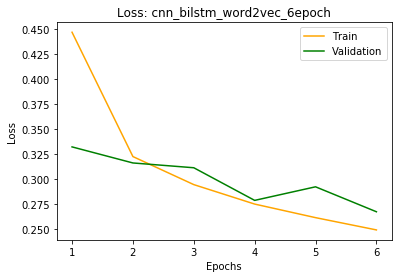

In [2]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: cnn_bilstm_word2vec_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_bilstm_word2vec_12epoch_loss.png', dpi=900)

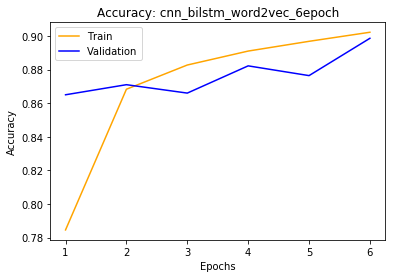

In [3]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: cnn_bilstm_word2vec_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/cnn_bilstm_word2vec_12epoch_accuracy.png', dpi=900)